# **Packages setup** 

In [1]:
import  random
random.seed(77573011183960929)
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from google.colab import drive

# **Upload the Dataset**

In [ ]:
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Capstone

In [ ]:
base_dir = 'GAMEEMO'
data_type = 'preprocessed'
labels_data_path = '/content/drive/MyDrive/Capstone/game_labels_from_pdf.csv'

In [ ]:
all_file_path = []
subjects = os.listdir(base_dir)
for subject in subjects:
  subject_loc = os.path.join(base_dir,subject)
  subject_data = os.listdir(subject_loc)
  selected_data_type = ''
  for subject_data_type in subject_data:
    if data_type.lower() in subject_data_type.lower():
      selected_data_type = subject_data_type
  data_type_path = os.path.join(subject_loc, selected_data_type)
  data_type_path = os.path.join(data_type_path,'.csv format')
  for file_name in os.listdir(data_type_path):
    all_file_path.append(os.path.join(data_type_path,file_name))
all_file_path

['GAMEEMO/(S05)/Preprocessed EEG Data/.csv format/S05G2AllChannels.csv',
 'GAMEEMO/(S05)/Preprocessed EEG Data/.csv format/S05G4AllChannels.csv',
 'GAMEEMO/(S05)/Preprocessed EEG Data/.csv format/S05G3AllChannels.csv',
 'GAMEEMO/(S05)/Preprocessed EEG Data/.csv format/S05G1AllChannels.csv',
 'GAMEEMO/(S22)/Preprocessed EEG Data/.csv format/S22G1AllChannels.csv',
 'GAMEEMO/(S22)/Preprocessed EEG Data/.csv format/S22G3AllChannels.csv',
 'GAMEEMO/(S22)/Preprocessed EEG Data/.csv format/S22G2AllChannels.csv',
 'GAMEEMO/(S22)/Preprocessed EEG Data/.csv format/S22G4AllChannels.csv',
 'GAMEEMO/(S18)/Preprocessed EEG Data/.csv format/S18G3AllChannels.csv',
 'GAMEEMO/(S18)/Preprocessed EEG Data/.csv format/S18G1AllChannels.csv',
 'GAMEEMO/(S18)/Preprocessed EEG Data/.csv format/S18G2AllChannels.csv',
 'GAMEEMO/(S18)/Preprocessed EEG Data/.csv format/S18G4AllChannels.csv',
 'GAMEEMO/(S08)/Preprocessed EEG Data/.csv format/S08G2AllChannels.csv',
 'GAMEEMO/(S08)/Preprocessed EEG Data/.csv format/S

In [ ]:
labels_data = pd.read_csv(labels_data_path, usecols  = ['subject','game','boring','horrible','calm','funny'])


In [ ]:
labels_data

,subject,game,boring,horrible,calm,funny
0,1,1,8,1,3,2
1,1,2,2,1,8,8
2,1,3,2,8,1,1
3,1,4,1,1,3,9
4,2,1,8,1,4,2
...,...,...,...,...,...,...
103,26,4,1,1,5,7
104,27,1,6,1,8,2
105,27,2,1,1,10,8
106,27,3,1,10,1,1


In [ ]:
#Upload the data into data_array and the labels into labels_array
data_array = []
labels_array = []
for file_ in all_file_path:
  file_name = os.path.basename(file_)
  subject = int(file_name[1:3])
  game = int(file_name[4])
  subject_labels = labels_data.loc[labels_data['subject'] == subject]
  game_labels = subject_labels.loc[subject_labels['game'] == game]
  
  if len(game_labels):
    subject_data = pd.read_csv(file_)
    data_array.append(subject_data.iloc[25:,:14].to_numpy())
    labels_array.append(game_labels.iloc[:,2:].to_numpy())

data_array = np.array(data_array)
data_shape = data_array.shape
data_array = data_array.reshape(data_shape[0],301,127,14)
labels_array = np.array(labels_array)
labels_array = labels_array.reshape(labels_array.shape[0],labels_array.shape[2])

In [ ]:
print(data_array.shape)
print(labels_array.shape)

(108, 301, 127, 14)
(108, 4)


# **Create the model**

In [ ]:
def get_model(input_size):
     #Initialising the CNN
    model = tf.keras.models.Sequential()  

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
  
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(4, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(learning_rate=0.000001, decay=1e-6), 
                  loss=tf.keras.losses.MeanSquaredError(), 
                  metrics=['accuracy'])
    return model

In [ ]:
model = get_model((data_array.shape[1:]))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 299, 125, 64)      8128      
                                                                 
 conv2d_33 (Conv2D)          (None, 297, 123, 64)      36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 148, 61, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 146, 59, 64)       36928     
                                                                 
 conv2d_35 (Conv2D)          (None, 144, 57, 32)       18464     
                                                                 
 batch_normalization_12 (Bat  (None, 144, 57, 32)      128       
 chNormalization)                                     

# **Data splitting and training**

In [ ]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(data_array, labels_array, test_size = 0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=42)

In [ ]:
#Create a checkpoint to save the best model
checkpoint = ModelCheckpoint(filepath='best_model.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='max',
                             monitor='val_accuracy')

#Reduce learning rate when val_accuracy has stopped improving          
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=10, 
                              verbose=1, 
                              min_delta=0.0001)

callbacks = [checkpoint]

In [ ]:
#Model training
hist = model.fit(X_train, y_train,
                 validation_data = (X_val,y_val),
                 epochs=300,
                 callbacks = callbacks,
                 batch_size = 64)

Epoch 1/300
2/2 [==============================] - ETA: 0s - loss: 22.8131 - accuracy: 0.2907
Epoch 1: val_accuracy improved from -inf to 0.36364, saving model to best_model.h5
2/2 [==============================] - 2s 581ms/step - loss: 22.8131 - accuracy: 0.2907 - val_loss: 21.4365 - val_accuracy: 0.3636
Epoch 2/300
2/2 [==============================] - ETA: 0s - loss: 22.8473 - accuracy: 0.2791
Epoch 2: val_accuracy did not improve from 0.36364
2/2 [==============================] - 0s 159ms/step - loss: 22.8473 - accuracy: 0.2791 - val_loss: 21.4439 - val_accuracy: 0.3636
Epoch 3/300
2/2 [==============================] - ETA: 0s - loss: 22.8071 - accuracy: 0.2442
Epoch 3: val_accuracy did not improve from 0.36364
2/2 [==============================] - 0s 161ms/step - loss: 22.8071 - accuracy: 0.2442 - val_loss: 21.4513 - val_accuracy: 0.3636
Epoch 4/300
2/2 [==============================] - ETA: 0s - loss: 22.7429 - accuracy: 0.2907
Epoch 4: val_accuracy did not improve from 0.3

# **Performance Evaluation**

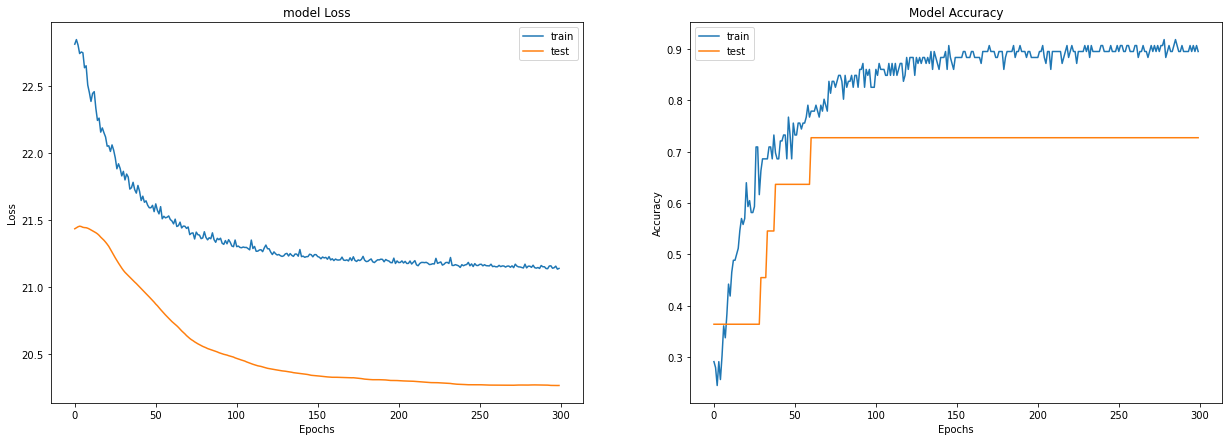

In [ ]:
plt.figure(figsize=(21,7))

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

plt.show()

In [ ]:
model = tf.keras.models.load_model('best_model.h5', compile=False)
model.compile(optimizer=Adam(learning_rate=0.000001, decay=1e-6), 
                  loss=tf.keras.losses.MeanSquaredError(), 
                  metrics=['accuracy'])
test_loss, test_accu = model.evaluate(X_test,y_test)
print(test_loss, test_accu)

1/1 [==============================] - 0s 402ms/step - loss: 21.2506 - accuracy: 0.9091
21.25061798095703 0.9090909361839294


# Gird search

In [ ]:
def build_clf(opt = 'Adam'):
     #Initialising the CNN
    model = tf.keras.models.Sequential()  

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape =(301, 127, 14)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
  
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())

    
    model.add(Dense(4, activation='softmax'))

    #Compliling the model
    model.compile(optimizer = opt, 
                  loss=tf.keras.losses.MeanSquaredError(), 
                  metrics=['accuracy'])
    return model

In [ ]:
optimizer = ['SGD', 'RMSprop', 'Adam', 'Adamax']
batch_size = [16,32,64]

In [ ]:
all_hists = []
for opt in optimizer:
  for batch_siz in batch_size:
    model = build_clf(opt = opt)
    hist = model.fit(X_train, y_train,
                 validation_data = (X_val,y_val),
                 epochs=100,
                 batch_size = batch_siz,
                 verbose = 0)
    all_hists.append(hist)
    test_loss, test_accu = model.evaluate(X_test,y_test,verbose=0)
    print('Optimizer:',opt,'Batch size:',batch_siz,'test Loss:',test_loss,'test Accuracy:', test_accu)

Optimizer: SGD Batch size: 16 test Loss: 21.589990615844727 test Accuracy: 0.8181818127632141
Optimizer: SGD Batch size: 32 test Loss: 21.902381896972656 test Accuracy: 0.7272727489471436
Optimizer: SGD Batch size: 64 test Loss: 21.671125411987305 test Accuracy: 0.7272727489471436
Optimizer: RMSprop Batch size: 16 test Loss: 21.471269607543945 test Accuracy: 0.7272727489471436
Optimizer: RMSprop Batch size: 32 test Loss: 21.6546688079834 test Accuracy: 0.6363636255264282
Optimizer: RMSprop Batch size: 64 test Loss: 21.75480079650879 test Accuracy: 0.6363636255264282
Optimizer: Adam Batch size: 16 test Loss: 21.53351593017578 test Accuracy: 0.8181818127632141
Optimizer: Adam Batch size: 32 test Loss: 21.86963653564453 test Accuracy: 0.5454545617103577
Optimizer: Adam Batch size: 64 test Loss: 21.99765968322754 test Accuracy: 0.6363636255264282
Optimizer: Adamax Batch size: 16 test Loss: 21.879409790039062 test Accuracy: 0.7272727489471436
Optimizer: Adamax Batch size: 32 test Loss: 21.9

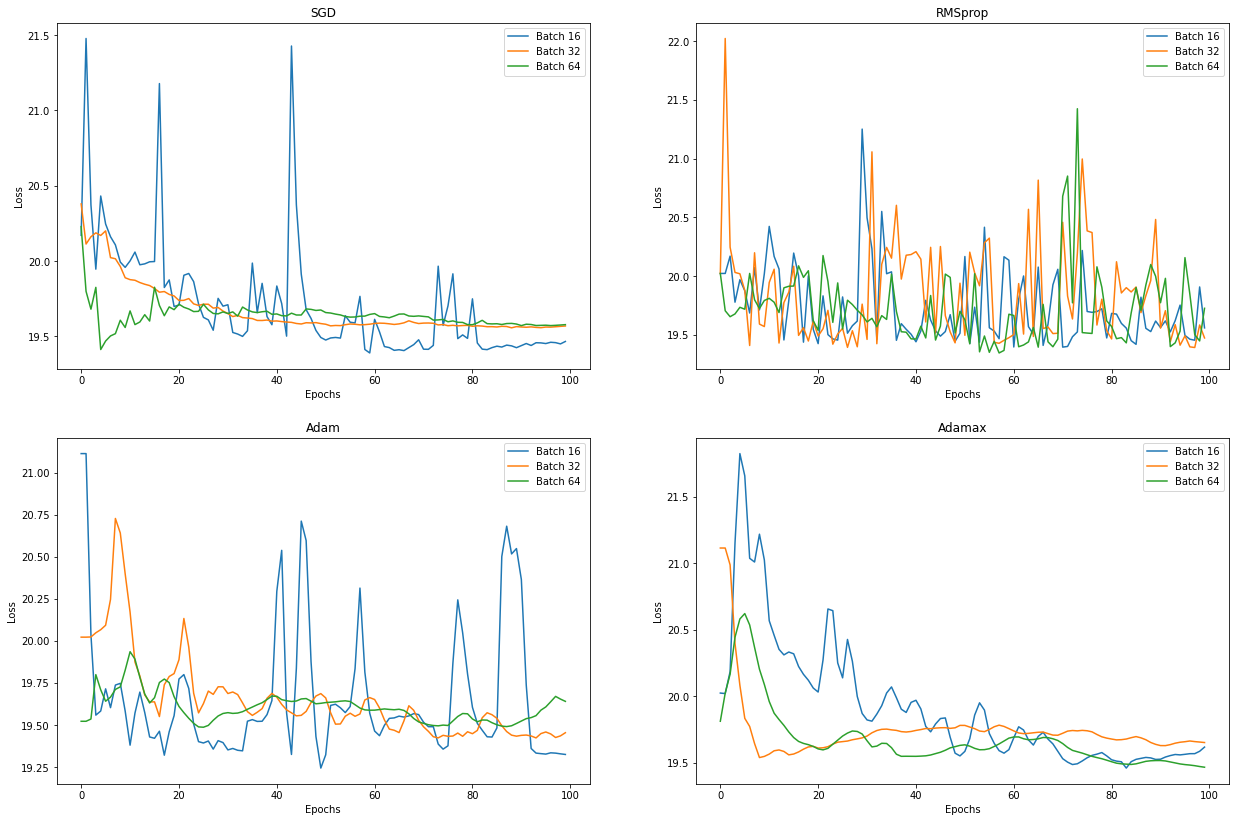

In [ ]:
#Plot the loss of all selected hyper-parameters

plt.figure(figsize=(21,14))


plt.subplot(2,2,1)
plt.title('SGD')
plt.plot(all_hists[0].history['val_loss'],label = 'Batch 16')
plt.plot(all_hists[1].history['val_loss'],label = 'Batch 32')
plt.plot(all_hists[2].history['val_loss'],label = 'Batch 64')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,2,2)
plt.title('RMSprop')
plt.plot(all_hists[3].history['val_loss'],label = 'Batch 16')
plt.plot(all_hists[4].history['val_loss'],label = 'Batch 32')
plt.plot(all_hists[5].history['val_loss'],label = 'Batch 64')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(2,2,3)
plt.title('Adam')
plt.plot(all_hists[6].history['val_loss'],label = 'Batch 16')
plt.plot(all_hists[7].history['val_loss'],label = 'Batch 32')
plt.plot(all_hists[8].history['val_loss'],label = 'Batch 64')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,2,4)
plt.title('Adamax')
plt.plot(all_hists[9].history['val_loss'],label = 'Batch 16')
plt.plot(all_hists[10].history['val_loss'],label = 'Batch 32')
plt.plot(all_hists[11].history['val_loss'],label = 'Batch 64')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

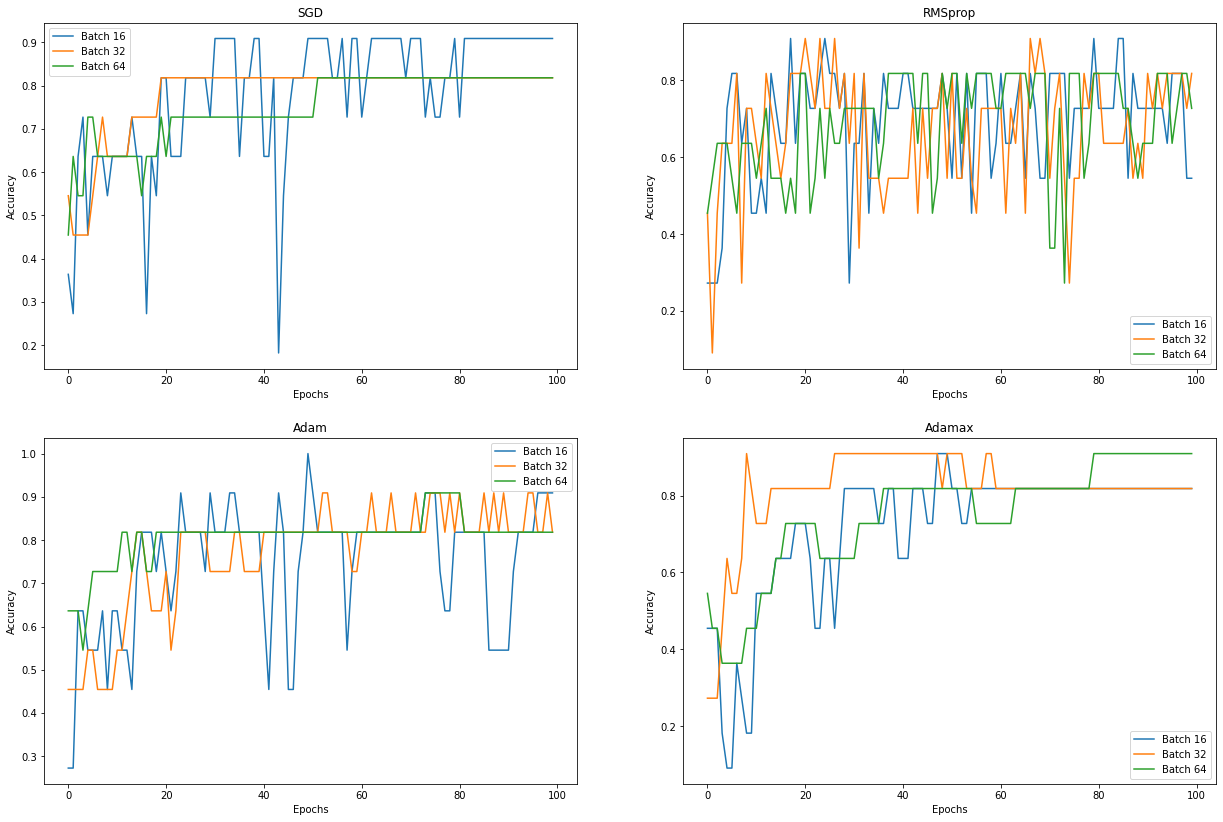

In [ ]:
#Plot the accuracy of all selected hyper-parameters

plt.figure(figsize=(21,14))


plt.subplot(2,2,1)
plt.title('SGD')
plt.plot(all_hists[0].history['val_accuracy'],label = 'Batch 16')
plt.plot(all_hists[1].history['val_accuracy'],label = 'Batch 32')
plt.plot(all_hists[2].history['val_accuracy'],label = 'Batch 64')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,2)
plt.title('RMSprop')
plt.plot(all_hists[3].history['val_accuracy'],label = 'Batch 16')
plt.plot(all_hists[4].history['val_accuracy'],label = 'Batch 32')
plt.plot(all_hists[5].history['val_accuracy'],label = 'Batch 64')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,3)
plt.title('Adam')
plt.plot(all_hists[6].history['val_accuracy'],label = 'Batch 16')
plt.plot(all_hists[7].history['val_accuracy'],label = 'Batch 32')
plt.plot(all_hists[8].history['val_accuracy'],label = 'Batch 64')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2,2,4)
plt.title('Adamax')
plt.plot(all_hists[9].history['val_accuracy'],label = 'Batch 16')
plt.plot(all_hists[10].history['val_accuracy'],label = 'Batch 32')
plt.plot(all_hists[11].history['val_accuracy'],label = 'Batch 64')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()